# Importing dependencies

In [221]:
# !pip install snowflake

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from datetime import datetime
import snowflake.connector

from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# import shap
import xgboost as xgb

# Getting the data from Snowflake

In [223]:

# Set up connection parameters
account = 'ix15907.central-india.azure'
user = 'shreeom'
password = 'Qwerty@18606'
warehouse = 'COMPUTE_WH'
database = 'JMAN_FINAL_PROJECT'
schema = 'DBO_MART'
table = 'REGISTERED_FINAL'

# Establish connection
conn = snowflake.connector.connect(
    user=user,
    password=password,
    account=account,
    warehouse=warehouse,
    database=database,
    schema=schema
)

# Create a cursor object
cur = conn.cursor()

# Execute a query to select data from the table
cur.execute(f'SELECT * FROM JMAN_FINAL_PROJECT.DBO_MART.REGISTERED_FINAL')

# Fetch the results
rows = cur.fetchall()

# Close the cursor and connection
cur.close()
conn.close()

# Convert the result into a pandas DataFrame for easier manipulation
df = pd.DataFrame(rows, columns=[x[0] for x in cur.description])

In [224]:
df.head(5)

USERR_ID  EVENT_ID                                            NAME  \
0        84        15    Advanced Data Engineering Techniques Seminar   
1        19        21  Full Stack Webinar Series: Frontend to Backend   
2        68        27      Data Science Summit: Cutting-Edge Research   
3        68        16       Data Analytics for Business Professionals   
4        88         4                 Full Stack Development Bootcamp   

             DOMAIN        DATE STARTTIME   ENDTIME LOCATION          TRAINER  \
0  data-engineering  17-10-2023  17:35:00  07:17:00    aurum  Dermot Matteoni   
1        full-stack  23-07-2023  18:33:00  02:24:00   falcon    Benjamen Pass   
2      data-science  29-09-2023  21:09:00  02:19:00   tardis    Anica Skeemor   
3    data-analytics  24-05-2024  14:48:00  01:59:00   jarvis    Cordey Panton   
4        full-stack  04-07-2023  19:09:00  03:37:00    aurum   Selma Eathorne   

   CAPACITY  REGISTERED                                      RESOURCE_LINK  \
0        50           0  https://drive.google.com/file/d/16FgMGtttyemBP...   
1        40           0  https://drive.google.com/file/d/16FgMGtttyemBP...   
2        40           0  https://drive.google.com/file/d/16FgMGtttyemBP...   
3        50           0  https://drive.google.com/file/d/16FgMGtttyemBP...   
4        50           0  https://drive.google.com/file/d/16FgMGtttyemBP...   

   DESCRIPTION  ID FIRST_NAME LAST_NAME                   EMAIL  GENDER  \
0  description  84       Adel  Schenkel  aschenkel2b@ustream.tv  Female   
1  description  19      Kiley      Cafe           kcafei@un.org  Female   
2  description  68     Cletis   Privett       cprivett1v@ft.com    Male   
3  description  68     Cletis   Privett       cprivett1v@ft.com    Male   
4  description  88     Isador  Chillcot   ichillcot2f@amazon.de    Male   

  DESIGNATION  C7  
0      intern   7  
1      intern  10  
2  consultant   1  
3  consultant   1  
4  consultant   0

# Getting the data from csv where data is saved

In [4]:

users = pd.read_csv('./Jman-final-project-datasets/users.csv')
user_skills = pd.read_csv('./Jman-final-project-datasets/user_skill.csv')
skills = pd.read_csv('./Jman-final-project-datasets/skill.csv')
registrations = pd.read_csv('./Jman-final-project-datasets/Registerations.csv')
interests = pd.read_csv('./Jman-final-project-datasets/interest.csv')
events = pd.read_csv('./Jman-final-project-datasets/event.csv')

In [6]:
dataset = pd.read_csv('./elearning_platform.csv')
dataset


In [227]:
df = dataset.copy()
df

USERR_ID  EVENT_ID                                              NAME  \
0          84        15      Advanced Data Engineering Techniques Seminar   
1          19        21    Full Stack Webinar Series: Frontend to Backend   
2          68        27        Data Science Summit: Cutting-Edge Research   
3          68        16         Data Analytics for Business Professionals   
4          88         4                   Full Stack Development Bootcamp   
..        ...       ...                                               ...   
995        45        13      Full Stack Showcase: Projects and Portfolios   
996         7         6                       Databases Conference & Expo   
997        53        12  Full Stack Tech Talks: Cutting-Edge Technologies   
998        34        13      Full Stack Showcase: Projects and Portfolios   
999        77        25             Data Science Symposium: AI and Beyond   

               DOMAIN        DATE STARTTIME   ENDTIME LOCATION  \
0    data-engineering  17-10-2023  17:35:00  07:17:00    aurum   
1          full-stack  23-07-2023  18:33:00  02:24:00   falcon   
2        data-science  29-09-2023  21:09:00  02:19:00   tardis   
3      data-analytics  24-05-2024  14:48:00  01:59:00   jarvis   
4          full-stack  04-07-2023  19:09:00  03:37:00    aurum   
..                ...         ...       ...       ...      ...   
995        full-stack  02-04-2024  17:53:00  03:11:00   tardis   
996          database  04-04-2024  14:51:00  00:41:00   tardis   
997        full-stack  13-12-2023  16:33:00  09:04:00   falcon   
998        full-stack  02-04-2024  17:53:00  03:11:00   tardis   
999      data-science  25-12-2023  18:56:00  08:19:00    aurum   

              TRAINER  CAPACITY  ...  Javascript   Node Python  \
0     Dermot Matteoni        50  ...        True   True  False   
1       Benjamen Pass        40  ...        True  False  False   
2       Anica Skeemor        40  ...       False  False  False   
3       Cordey Panton        50  ...       False  False  False   
4      Selma Eathorne        50  ...        True   True   True   
..                ...       ...  ...         ...    ...    ...   
995  Clemmie Gallaher        50  ...       False   True   True   
996  Kathryn Monckton        50  ...       False   True   True   
997     Murry Geharke        50  ...        True   True   True   
998  Clemmie Gallaher        50  ...       False   True  False   
999    Jackelyn Gyves        40  ...        True   True   True   

     Machine_Learning  NoSQL    ETL Data_Warehouse Big_Data   HTML    SQL  
0               False   True   True          False     True   True   True  
1               False   True  False           True     True   True  False  
2               False   True   True           True     True  False  False  
3               False   True   True           True     True  False  False  
4               False  False   True           True     True   True   True  
..                ...    ...    ...            ...      ...    ...    ...  
995              True  False  False          False     True  False  False  
996             False  False   True          False     True   True  False  
997              True  False  False          False    False   True   True  
998             False   True  False           True     True   True   True  
999              True  False  False          False     True   True   True  

[1000 rows x 31 columns]

In [228]:
df.shape

(1000, 31)

In [229]:
df.describe()

USERR_ID     EVENT_ID    CAPACITY  REGISTERED           ID  \
count  1000.000000  1000.000000  1000.00000      1000.0  1000.000000   
mean     49.438000    15.454000    46.42000         0.0    49.438000   
std      28.584213     8.637157     4.79652         0.0    28.584213   
min       1.000000     1.000000    40.00000         0.0     1.000000   
25%      24.750000     8.000000    40.00000         0.0    24.750000   
50%      49.000000    15.000000    50.00000         0.0    49.000000   
75%      74.000000    23.000000    50.00000         0.0    74.000000   
max     100.000000    30.000000    50.00000         0.0   100.000000   

        EXPERIENCE  
count  1000.000000  
mean      4.929000  
std       3.239823  
min       0.000000  
25%       2.000000  
50%       5.000000  
75%       7.000000  
max      10.000000

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   USERR_ID          1000 non-null   int64 
 1   EVENT_ID          1000 non-null   int64 
 2   NAME              1000 non-null   object
 3   DOMAIN            1000 non-null   object
 4   DATE              1000 non-null   object
 5   STARTTIME         1000 non-null   object
 6   ENDTIME           1000 non-null   object
 7   LOCATION          1000 non-null   object
 8   TRAINER           1000 non-null   object
 9   CAPACITY          1000 non-null   int64 
 10  REGISTERED        1000 non-null   int64 
 11  RESOURCE_LINK     1000 non-null   object
 12  DESCRIPTION       1000 non-null   object
 13  ID                1000 non-null   int64 
 14  FIRST_NAME        1000 non-null   object
 15  LAST_NAME         1000 non-null   object
 16  EMAIL             1000 non-null   object
 17  GENDER         

In [231]:
null_count = df.isnull().sum()
null_count

USERR_ID            0
EVENT_ID            0
NAME                0
DOMAIN              0
DATE                0
STARTTIME           0
ENDTIME             0
LOCATION            0
TRAINER             0
CAPACITY            0
REGISTERED          0
RESOURCE_LINK       0
DESCRIPTION         0
ID                  0
FIRST_NAME          0
LAST_NAME           0
EMAIL               0
GENDER              0
DESIGNATION         0
EXPERIENCE          0
React               0
Javascript          0
Node                0
Python              0
Machine_Learning    0
NoSQL               0
ETL                 0
Data_Warehouse      0
Big_Data            0
HTML                0
SQL                 0
dtype: int64

In [232]:
percentage_null = (null_count / len(df)) * 100
percentage_null

USERR_ID            0.0
EVENT_ID            0.0
NAME                0.0
DOMAIN              0.0
DATE                0.0
STARTTIME           0.0
ENDTIME             0.0
LOCATION            0.0
TRAINER             0.0
CAPACITY            0.0
REGISTERED          0.0
RESOURCE_LINK       0.0
DESCRIPTION         0.0
ID                  0.0
FIRST_NAME          0.0
LAST_NAME           0.0
EMAIL               0.0
GENDER              0.0
DESIGNATION         0.0
EXPERIENCE          0.0
React               0.0
Javascript          0.0
Node                0.0
Python              0.0
Machine_Learning    0.0
NoSQL               0.0
ETL                 0.0
Data_Warehouse      0.0
Big_Data            0.0
HTML                0.0
SQL                 0.0
dtype: float64

In [233]:
df

USERR_ID  EVENT_ID                                              NAME  \
0          84        15      Advanced Data Engineering Techniques Seminar   
1          19        21    Full Stack Webinar Series: Frontend to Backend   
2          68        27        Data Science Summit: Cutting-Edge Research   
3          68        16         Data Analytics for Business Professionals   
4          88         4                   Full Stack Development Bootcamp   
..        ...       ...                                               ...   
995        45        13      Full Stack Showcase: Projects and Portfolios   
996         7         6                       Databases Conference & Expo   
997        53        12  Full Stack Tech Talks: Cutting-Edge Technologies   
998        34        13      Full Stack Showcase: Projects and Portfolios   
999        77        25             Data Science Symposium: AI and Beyond   

               DOMAIN        DATE STARTTIME   ENDTIME LOCATION  \
0    data-engineering  17-10-2023  17:35:00  07:17:00    aurum   
1          full-stack  23-07-2023  18:33:00  02:24:00   falcon   
2        data-science  29-09-2023  21:09:00  02:19:00   tardis   
3      data-analytics  24-05-2024  14:48:00  01:59:00   jarvis   
4          full-stack  04-07-2023  19:09:00  03:37:00    aurum   
..                ...         ...       ...       ...      ...   
995        full-stack  02-04-2024  17:53:00  03:11:00   tardis   
996          database  04-04-2024  14:51:00  00:41:00   tardis   
997        full-stack  13-12-2023  16:33:00  09:04:00   falcon   
998        full-stack  02-04-2024  17:53:00  03:11:00   tardis   
999      data-science  25-12-2023  18:56:00  08:19:00    aurum   

              TRAINER  CAPACITY  ...  Javascript   Node Python  \
0     Dermot Matteoni        50  ...        True   True  False   
1       Benjamen Pass        40  ...        True  False  False   
2       Anica Skeemor        40  ...       False  False  False   
3       Cordey Panton        50  ...       False  False  False   
4      Selma Eathorne        50  ...        True   True   True   
..                ...       ...  ...         ...    ...    ...   
995  Clemmie Gallaher        50  ...       False   True   True   
996  Kathryn Monckton        50  ...       False   True   True   
997     Murry Geharke        50  ...        True   True   True   
998  Clemmie Gallaher        50  ...       False   True  False   
999    Jackelyn Gyves        40  ...        True   True   True   

     Machine_Learning  NoSQL    ETL Data_Warehouse Big_Data   HTML    SQL  
0               False   True   True          False     True   True   True  
1               False   True  False           True     True   True  False  
2               False   True   True           True     True  False  False  
3               False   True   True           True     True  False  False  
4               False  False   True           True     True   True   True  
..                ...    ...    ...            ...      ...    ...    ...  
995              True  False  False          False     True  False  False  
996             False  False   True          False     True   True  False  
997              True  False  False          False    False   True   True  
998             False   True  False           True     True   True   True  
999              True  False  False          False     True   True   True  

[1000 rows x 31 columns]

In [234]:
df.head(5)

USERR_ID  EVENT_ID                                            NAME  \
0        84        15    Advanced Data Engineering Techniques Seminar   
1        19        21  Full Stack Webinar Series: Frontend to Backend   
2        68        27      Data Science Summit: Cutting-Edge Research   
3        68        16       Data Analytics for Business Professionals   
4        88         4                 Full Stack Development Bootcamp   

             DOMAIN        DATE STARTTIME   ENDTIME LOCATION          TRAINER  \
0  data-engineering  17-10-2023  17:35:00  07:17:00    aurum  Dermot Matteoni   
1        full-stack  23-07-2023  18:33:00  02:24:00   falcon    Benjamen Pass   
2      data-science  29-09-2023  21:09:00  02:19:00   tardis    Anica Skeemor   
3    data-analytics  24-05-2024  14:48:00  01:59:00   jarvis    Cordey Panton   
4        full-stack  04-07-2023  19:09:00  03:37:00    aurum   Selma Eathorne   

   CAPACITY  ...  Javascript   Node Python  Machine_Learning  NoSQL    ETL  \
0        50  ...        True   True  False             False   True   True   
1        40  ...        True  False  False             False   True  False   
2        40  ...       False  False  False             False   True   True   
3        50  ...       False  False  False             False   True   True   
4        50  ...        True   True   True             False  False   True   

  Data_Warehouse Big_Data   HTML    SQL  
0          False     True   True   True  
1           True     True   True  False  
2           True     True  False  False  
3           True     True  False  False  
4           True     True   True   True  

[5 rows x 31 columns]

In [235]:
df.columns

Index(['USERR_ID', 'EVENT_ID', 'NAME', 'DOMAIN', 'DATE', 'STARTTIME',
       'ENDTIME', 'LOCATION', 'TRAINER', 'CAPACITY', 'REGISTERED',
       'RESOURCE_LINK', 'DESCRIPTION', 'ID', 'FIRST_NAME', 'LAST_NAME',
       'EMAIL', 'GENDER', 'DESIGNATION', 'EXPERIENCE', 'React', 'Javascript',
       'Node', 'Python', 'Machine_Learning', 'NoSQL', 'ETL', 'Data_Warehouse',
       'Big_Data', 'HTML', 'SQL'],
      dtype='object')

# UNIVARIATE ANALYSIS

Setting the color theme for my plots

In [236]:
custom_palette = ['#8A2BE2', '#9932CC', '#9400D3', '#8B008B', '#800080', '#9370DB', '#BA55D3', '#DA70D6', '#D8BFD8']
sns.set_palette(custom_palette)

Distribution of Users by Gender

GENDER
Female    45
Male      55
Name: USERR_ID, dtype: int64


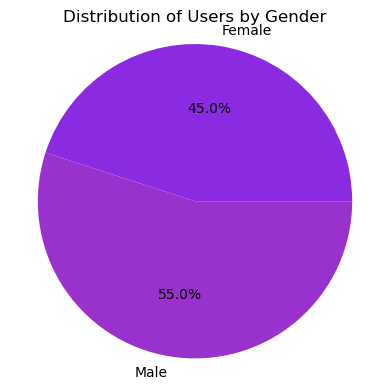

In [238]:

# Count the number of unique users for each gender
unique_users_by_gender = df.groupby('GENDER')['USERR_ID'].nunique()
print(unique_users_by_gender)
plt.figure(figsize=(4, 4))
plt.pie(unique_users_by_gender, labels=unique_users_by_gender.index, autopct='%1.1f%%', colors =custom_palette)
plt.title('Distribution of Users by Gender')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Show plot
plt.tight_layout()
plt.show()

Experience Distribution among the user

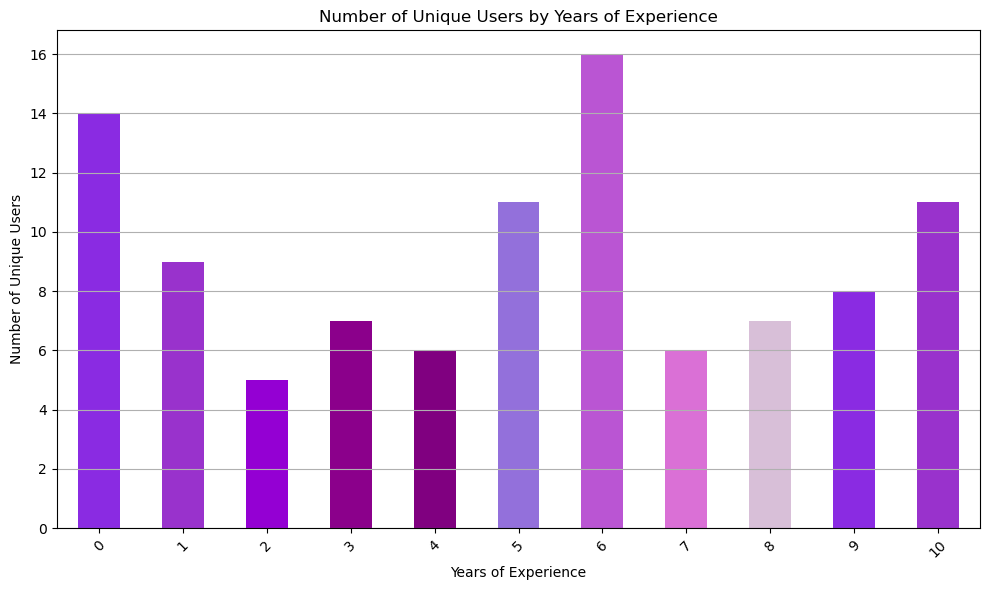

In [240]:
# Group by user ID and get the maximum experience for each user
max_experience_per_user = df.groupby('USERR_ID')['EXPERIENCE'].max()

# Count the number of unique users with each years of experience
users_by_experience = max_experience_per_user.value_counts().sort_index()

# Plot the distribution of years of experience
plt.figure(figsize=(10, 6))
users_by_experience.plot(kind='bar',color=custom_palette)
plt.title('Number of Unique Users by Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Number of Unique Users')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

Designation Distribution

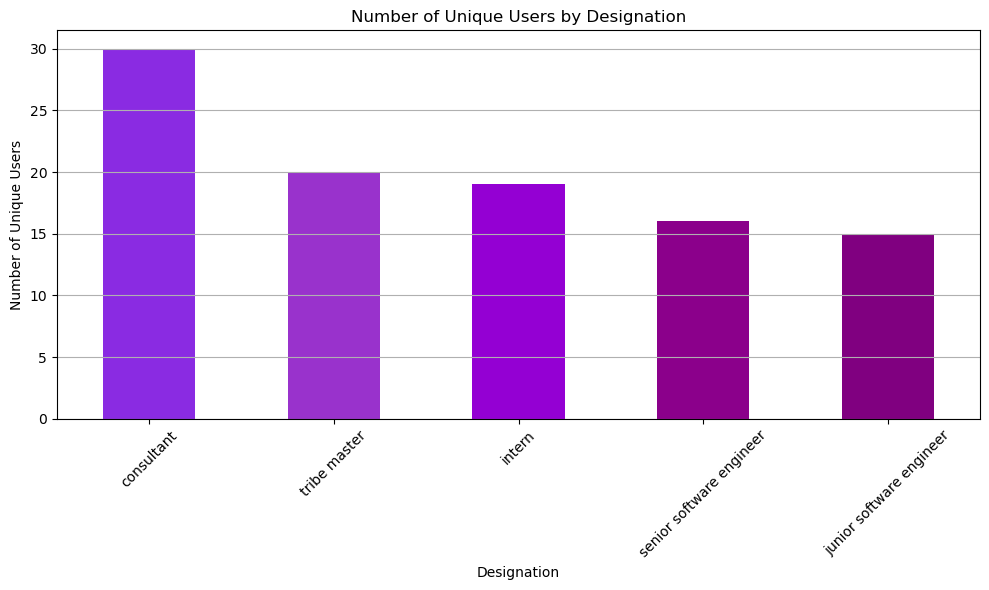

In [241]:
# Group by user ID and get the first designation for each user
first_designation_per_user = df.groupby('USERR_ID')['DESIGNATION'].first()

# Count the number of unique users with each designation
users_by_designation = first_designation_per_user.value_counts()
print()
# Plot the distribution of designations
plt.figure(figsize=(10, 6))
users_by_designation.plot(kind='bar', color=custom_palette)
plt.title('Number of Unique Users by Designation')
plt.xlabel('Designation')
plt.ylabel('Number of Unique Users')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

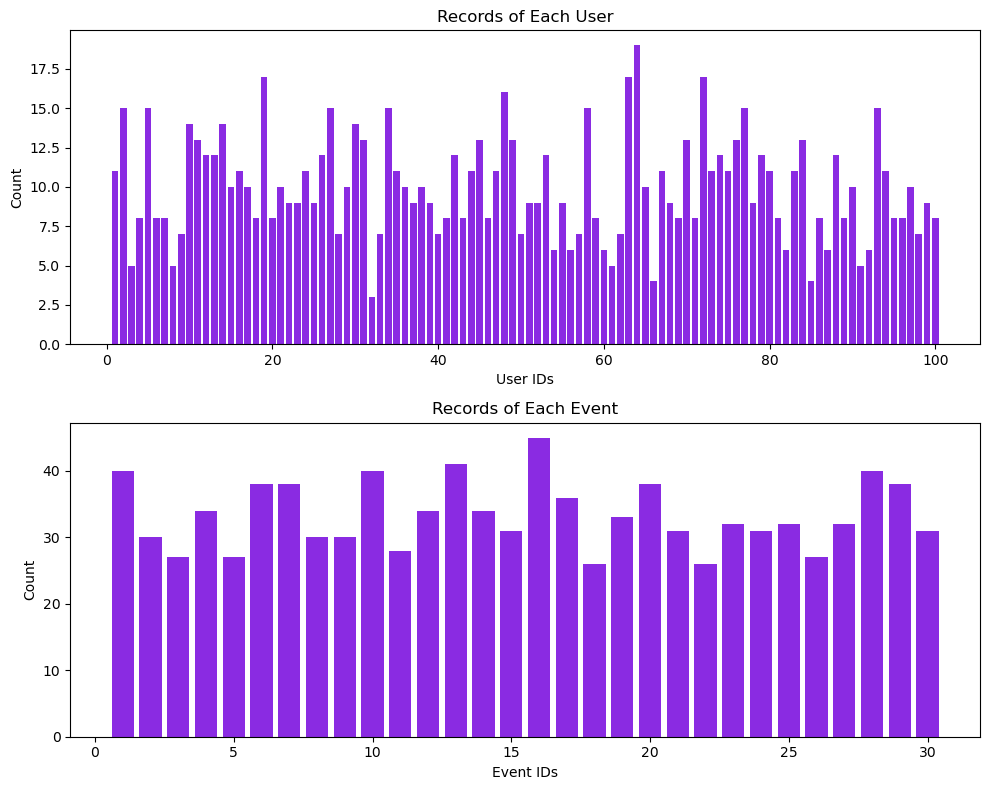

In [242]:
user_id_counts = df['USERR_ID'].value_counts()

# Count the occurrences of each event ID
event_id_counts = df['EVENT_ID'].value_counts()

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot the count of user IDs
axes[0].bar(user_id_counts.index, user_id_counts.values)
axes[0].set_title('Records of Each User')
axes[0].set_xlabel('User IDs')
axes[0].set_ylabel('Count')

# Plot the count of event IDs
axes[1].bar(event_id_counts.index, event_id_counts.values)
axes[1].set_title('Records of Each Event')
axes[1].set_xlabel('Event IDs')
axes[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

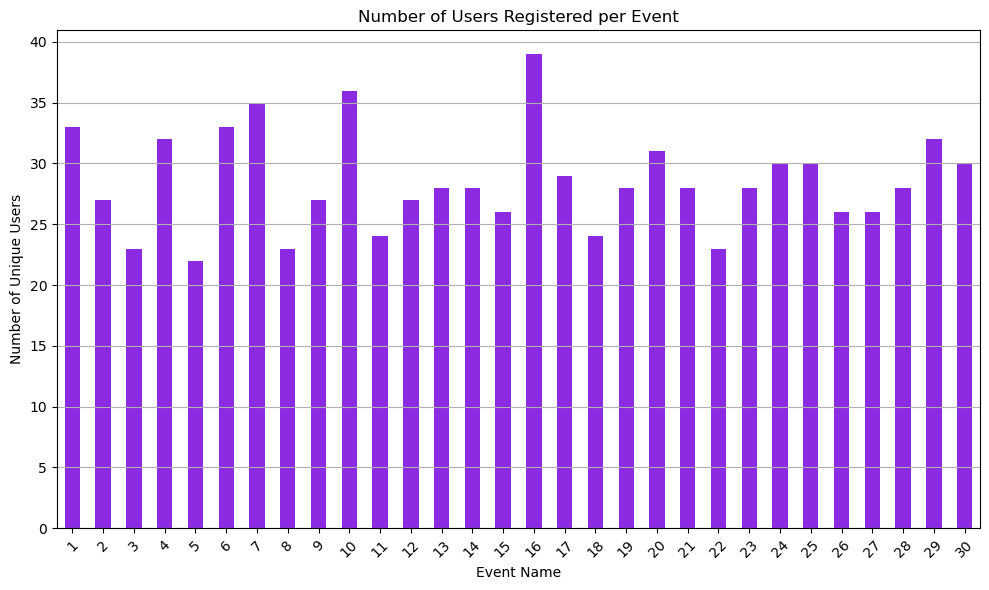

In [243]:
#  Group the data by event ID and count the number of unique user IDs
unique_users_per_event = df.groupby('EVENT_ID')['USERR_ID'].nunique()

# Create a bar plot
plt.figure(figsize=(10, 6))
unique_users_per_event.plot(kind='bar')
plt.title('Number of Users Registered per Event')
plt.xlabel('Event Name')
plt.ylabel('Number of Unique Users')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines for better visualization

# Show plot
plt.tight_layout()
plt.show()

Attendance per Event

In [244]:
# Group the data by event ID and count the number of unique user IDs
unique_users_per_event = df.groupby('EVENT_ID')['USERR_ID'].nunique()

# Reset the index to make 'EVENT_ID' a column again
unique_users_per_event = unique_users_per_event.reset_index()

# Rename the columns for clarity
unique_users_per_event.columns = ['EVENT_ID', 'Num_Registered_Users']

# Merge the unique_users_per_event DataFrame with the original DataFrame to get the capacity
merged_df = pd.merge(df, unique_users_per_event, on='EVENT_ID', how='left')

# Calculate attendance percentage
merged_df['Attendance_Percentage'] = (merged_df['Num_Registered_Users'] / merged_df['CAPACITY']) * 100

# Print the result
print(merged_df[['EVENT_ID', 'Attendance_Percentage']])

     EVENT_ID  Attendance_Percentage
0          15                   52.0
1          21                   70.0
2          27                   65.0
3          16                   78.0
4           4                   64.0
..        ...                    ...
995        13                   56.0
996         6                   66.0
997        12                   54.0
998        13                   56.0
999        25                   75.0

[1000 rows x 2 columns]


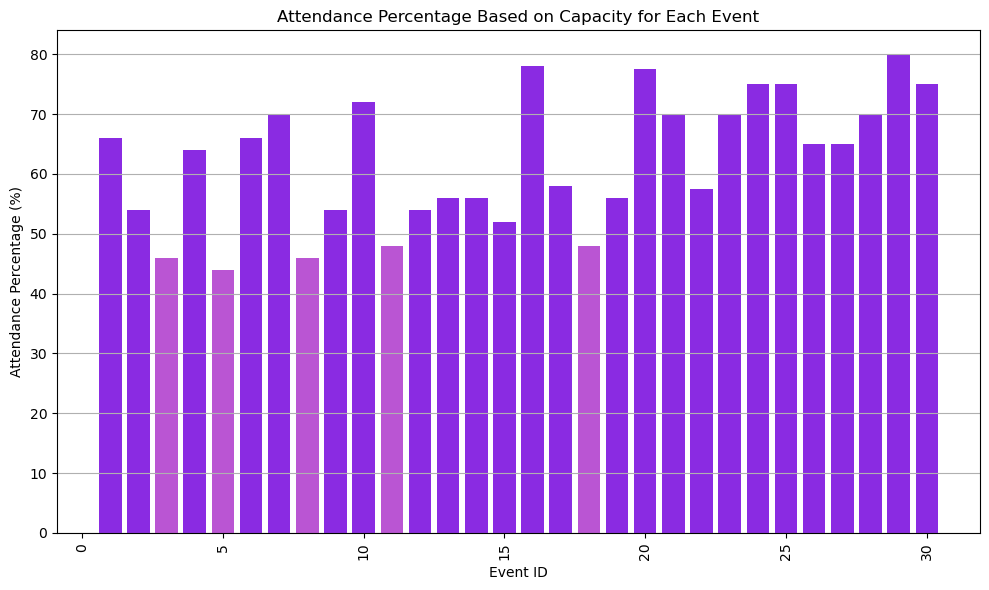

In [245]:
import matplotlib.pyplot as plt

# Set the color based on attendance percentage
colors = ['#BA55D3' if p < 50 else '#8A2BE2' for p in merged_df['Attendance_Percentage']]

plt.figure(figsize=(10, 6))
plt.bar(merged_df['EVENT_ID'], merged_df['Attendance_Percentage'], color=colors)
plt.title('Attendance Percentage Based on Capacity for Each Event')
plt.xlabel('Event ID')
plt.ylabel('Attendance Percentage (%)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines for better visualization

# Show plot
plt.tight_layout()
plt.show()


Registrations distribution over month

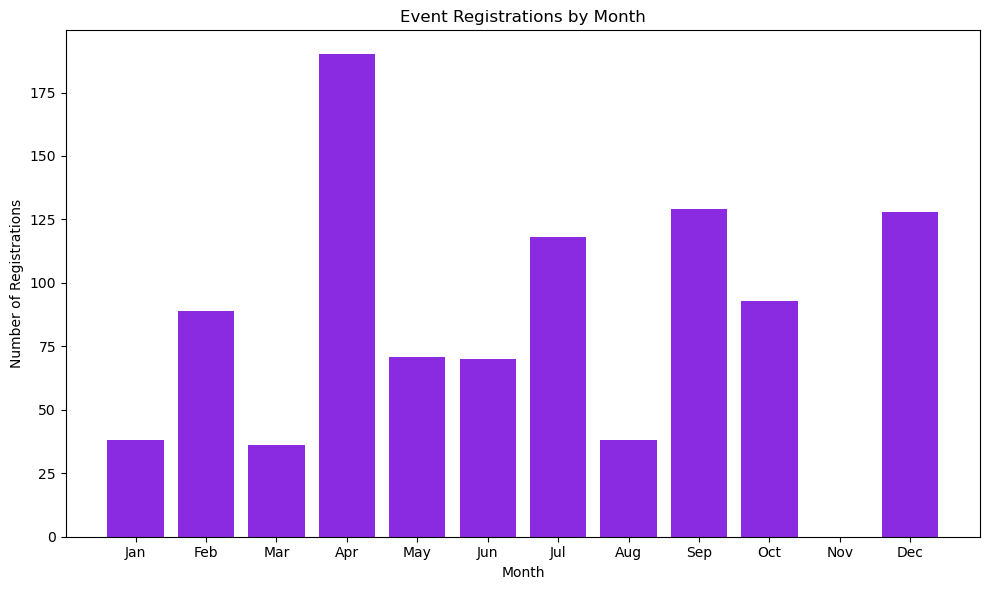

In [246]:

# Assuming you have a DataFrame 'df' with a 'Date' column in the format '24-05-2024'
# Convert the 'Date' column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%m-%Y')

# Extract the month from the 'Date' column
df['Month'] = df['DATE'].dt.month

# Group registrations by month and count
monthly_registrations = df.groupby('Month')['USERR_ID'].count()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_registrations.index, monthly_registrations.values)
plt.xlabel('Month')
plt.ylabel('Number of Registrations')
plt.title('Event Registrations by Month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
plt.tight_layout()
plt.show()


In [247]:
df.columns

Index(['USERR_ID', 'EVENT_ID', 'NAME', 'DOMAIN', 'DATE', 'STARTTIME',
       'ENDTIME', 'LOCATION', 'TRAINER', 'CAPACITY', 'REGISTERED',
       'RESOURCE_LINK', 'DESCRIPTION', 'ID', 'FIRST_NAME', 'LAST_NAME',
       'EMAIL', 'GENDER', 'DESIGNATION', 'EXPERIENCE', 'React', 'Javascript',
       'Node', 'Python', 'Machine_Learning', 'NoSQL', 'ETL', 'Data_Warehouse',
       'Big_Data', 'HTML', 'SQL', 'Month'],
      dtype='object')

Number of Events per Domain

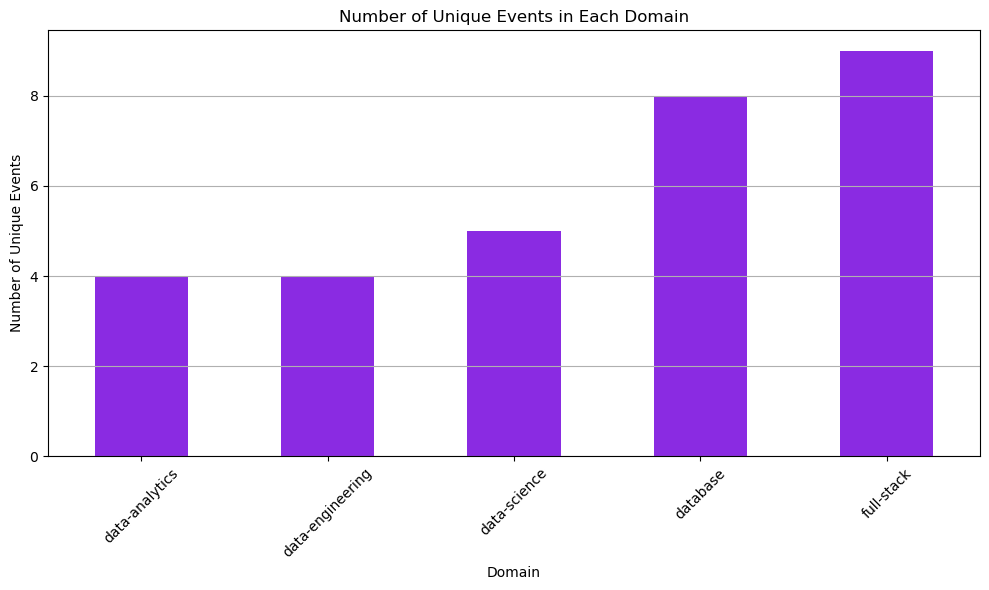

In [249]:

# Group the data by domain and count the number of unique events
unique_events_per_domain = df.groupby('DOMAIN')['EVENT_ID'].nunique()

# Create a bar plot
plt.figure(figsize=(10, 6))
unique_events_per_domain.plot(kind='bar')
plt.title('Number of Unique Events in Each Domain')
plt.xlabel('Domain')
plt.ylabel('Number of Unique Events')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines for better visualization

# Show plot

plt.tight_layout()
plt.show()

# BIVARIATE ANALYSIS

Skills Distribution over Users

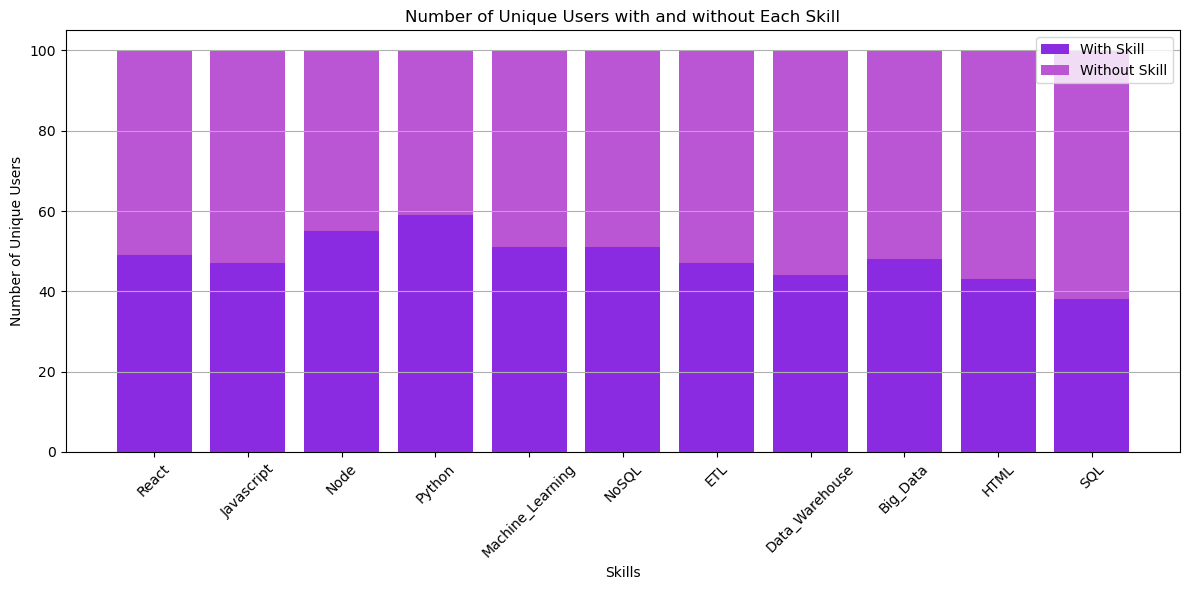

In [250]:


# List of skill column names
skill_columns = ['React', 'Javascript', 'Node', 'Python', 'Machine_Learning', 
                 'NoSQL', 'ETL', 'Data_Warehouse', 'Big_Data', 'HTML', 'SQL']

# Group by user ID and count the number of users who have each skill
users_with_skill = df.groupby('USERR_ID')[skill_columns].max().sum()

# Count the number of unique users
num_unique_users = df['USERR_ID'].nunique()

# Count the number of users who don't have each skill
users_without_skill = pd.Series(num_unique_users, index=skill_columns) - users_with_skill

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(skill_columns)), users_with_skill, color=custom_palette[0], label='With Skill')
plt.bar(range(len(skill_columns)), users_without_skill, bottom=users_with_skill, color=custom_palette[6], label='Without Skill')
plt.title('Number of Unique Users with and without Each Skill')
plt.xlabel('Skills')
plt.ylabel('Number of Unique Users')
plt.xticks(range(len(skill_columns)), skill_columns, rotation=45)
plt.legend()
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

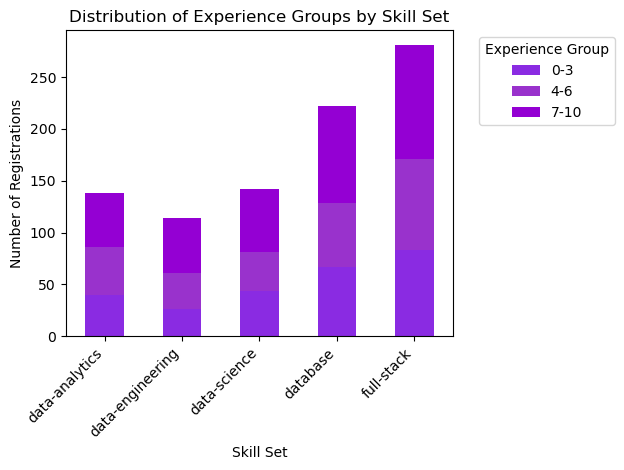

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with relevant columns
# Define the age groups
age_bins = [0, 3, 6, 10]
age_labels = ['0-3', '4-6', '7-10']

# Categorize 'EXPERIENCE' into age groups
df['EXPERIENCE_GROUP'] = pd.cut(df['EXPERIENCE'], bins=age_bins, labels=age_labels, right=False)

# Grouping the DataFrame by 'DOMAIN' and 'EXPERIENCE_GROUP' and counting the occurrences
skillset_experience_groups = df.groupby(['DOMAIN', 'EXPERIENCE_GROUP']).size().unstack(fill_value=0)

# Creating the bar plot
plt.figure(figsize=(12, 6))
skillset_experience_groups.plot(kind='bar', stacked=True)
plt.title('Distribution of Experience Groups by Skill Set')
plt.xlabel('Skill Set')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Experience Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Index(['React_registered', 'Javascript_registered', 'Node_registered',
       'Python_registered', 'Machine_Learning_registered', 'NoSQL_registered',
       'ETL_registered', 'Data_Warehouse_registered', 'Big_Data_registered',
       'HTML_registered', 'SQL_registered'],
      dtype='object')


<Axes: xlabel='DOMAIN'>

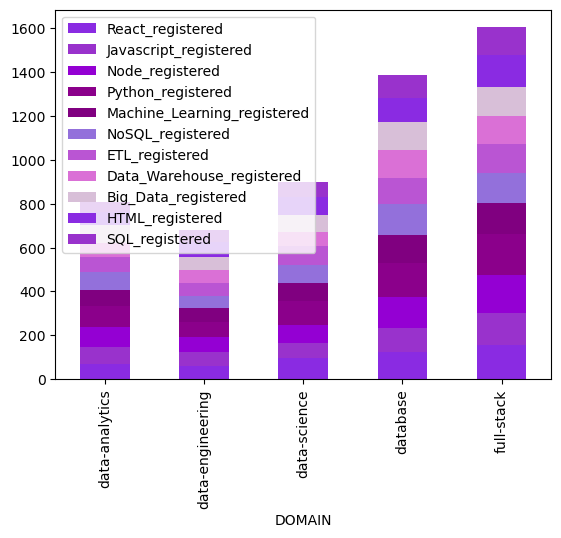

In [252]:
# Select relevant columns
skills_columns = ['React', 'Javascript', 'Node', 'Python', 'Machine_Learning', 'NoSQL', 'ETL', 'Data_Warehouse', 'Big_Data', 'HTML', 'SQL']
domain_column = 'DOMAIN'

# Create separate columns for each skill
for skill in skills_columns:
    df[f'{skill}_registered'] = df[skill]

# Group registrations by domain for each skill
registrations_by_domain = df.groupby(domain_column)[[f'{skill}_registered' for skill in skills_columns]].sum()

# Print the result (you can also visualize it
registrations_by_domain
print(registrations_by_domain.columns)
registrations_by_domain.plot(kind='bar', stacked=True)

# FEATURE ENGINEERING

Feature Creation

Duration of an event

In [253]:
df['STARTTIME'] = pd.to_datetime(df['STARTTIME'], format='%H:%M:%S')
df['ENDTIME'] = pd.to_datetime(df['ENDTIME'], format='%H:%M:%S')
df['DURATION'] = (df['STARTTIME'] - df['ENDTIME']).dt.total_seconds() / 3600
df['DURATION'] = df['DURATION'].abs()
df['DURATION'] = df['DURATION'].round()
df.head(5)

USERR_ID  EVENT_ID                                            NAME  \
0        84        15    Advanced Data Engineering Techniques Seminar   
1        19        21  Full Stack Webinar Series: Frontend to Backend   
2        68        27      Data Science Summit: Cutting-Edge Research   
3        68        16       Data Analytics for Business Professionals   
4        88         4                 Full Stack Development Bootcamp   

             DOMAIN       DATE           STARTTIME             ENDTIME  \
0  data-engineering 2023-10-17 1900-01-01 17:35:00 1900-01-01 07:17:00   
1        full-stack 2023-07-23 1900-01-01 18:33:00 1900-01-01 02:24:00   
2      data-science 2023-09-29 1900-01-01 21:09:00 1900-01-01 02:19:00   
3    data-analytics 2024-05-24 1900-01-01 14:48:00 1900-01-01 01:59:00   
4        full-stack 2023-07-04 1900-01-01 19:09:00 1900-01-01 03:37:00   

  LOCATION          TRAINER  CAPACITY  ...  Node_registered Python_registered  \
0    aurum  Dermot Matteoni        50  ...             True             False   
1   falcon    Benjamen Pass        40  ...            False             False   
2   tardis    Anica Skeemor        40  ...            False             False   
3   jarvis    Cordey Panton        50  ...            False             False   
4    aurum   Selma Eathorne        50  ...             True              True   

  Machine_Learning_registered  NoSQL_registered ETL_registered  \
0                       False              True           True   
1                       False              True          False   
2                       False              True           True   
3                       False              True           True   
4                       False             False           True   

  Data_Warehouse_registered Big_Data_registered HTML_registered  \
0                     False                True            True   
1                      True                True            True   
2                      True                True           False   
3                      True                True           False   
4                      True                True            True   

  SQL_registered  DURATION  
0           True      10.0  
1          False      16.0  
2          False      19.0  
3          False      13.0  
4           True      16.0  

[5 rows x 45 columns]

Month in which event is being hold

In [254]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%m-%Y')
df['MONTH'] = df['DATE'].dt.month
df.head(5)


USERR_ID  EVENT_ID                                            NAME  \
0        84        15    Advanced Data Engineering Techniques Seminar   
1        19        21  Full Stack Webinar Series: Frontend to Backend   
2        68        27      Data Science Summit: Cutting-Edge Research   
3        68        16       Data Analytics for Business Professionals   
4        88         4                 Full Stack Development Bootcamp   

             DOMAIN       DATE           STARTTIME             ENDTIME  \
0  data-engineering 2023-10-17 1900-01-01 17:35:00 1900-01-01 07:17:00   
1        full-stack 2023-07-23 1900-01-01 18:33:00 1900-01-01 02:24:00   
2      data-science 2023-09-29 1900-01-01 21:09:00 1900-01-01 02:19:00   
3    data-analytics 2024-05-24 1900-01-01 14:48:00 1900-01-01 01:59:00   
4        full-stack 2023-07-04 1900-01-01 19:09:00 1900-01-01 03:37:00   

  LOCATION          TRAINER  CAPACITY  ...  Python_registered  \
0    aurum  Dermot Matteoni        50  ...              False   
1   falcon    Benjamen Pass        40  ...              False   
2   tardis    Anica Skeemor        40  ...              False   
3   jarvis    Cordey Panton        50  ...              False   
4    aurum   Selma Eathorne        50  ...               True   

  Machine_Learning_registered NoSQL_registered  ETL_registered  \
0                       False             True            True   
1                       False             True           False   
2                       False             True            True   
3                       False             True            True   
4                       False            False            True   

  Data_Warehouse_registered Big_Data_registered HTML_registered  \
0                     False                True            True   
1                      True                True            True   
2                      True                True           False   
3                      True                True           False   
4                      True                True            True   

  SQL_registered DURATION  MONTH  
0           True     10.0     10  
1          False     16.0      7  
2          False     19.0      9  
3          False     13.0      5  
4           True     16.0      7  

[5 rows x 46 columns]

In [255]:

# Assuming you have a DataFrame 'df' with a 'STARTTIME' column
# Convert 'STARTTIME' to datetime format
df['STARTTIME'] = pd.to_datetime(df['STARTTIME'], format='%Y-%m-%d %H:%M:%S')

# Define time intervals
morning_start = datetime.strptime('06:00:00', '%H:%M:%S').time()
afternoon_start = datetime.strptime('12:00:00', '%H:%M:%S').time()
evening_start = datetime.strptime('18:00:00', '%H:%M:%S').time()
night_start = datetime.strptime('00:00:00', '%H:%M:%S').time()

# Categorize the STARTTIME
def categorize_time(time):
    if morning_start <= time < afternoon_start:
        return 'Morning'
    elif afternoon_start <= time < evening_start:
        return 'Afternoon'
    elif evening_start <= time or time < night_start:
        return 'Evening'
    elif night_start <= time or time < morning_start:
        return 'Night'

# Apply the categorization to the STARTTIME column
df['Time_Group'] = df['STARTTIME'].dt.time.apply(categorize_time)
df.head(5)


USERR_ID  EVENT_ID                                            NAME  \
0        84        15    Advanced Data Engineering Techniques Seminar   
1        19        21  Full Stack Webinar Series: Frontend to Backend   
2        68        27      Data Science Summit: Cutting-Edge Research   
3        68        16       Data Analytics for Business Professionals   
4        88         4                 Full Stack Development Bootcamp   

             DOMAIN       DATE           STARTTIME             ENDTIME  \
0  data-engineering 2023-10-17 1900-01-01 17:35:00 1900-01-01 07:17:00   
1        full-stack 2023-07-23 1900-01-01 18:33:00 1900-01-01 02:24:00   
2      data-science 2023-09-29 1900-01-01 21:09:00 1900-01-01 02:19:00   
3    data-analytics 2024-05-24 1900-01-01 14:48:00 1900-01-01 01:59:00   
4        full-stack 2023-07-04 1900-01-01 19:09:00 1900-01-01 03:37:00   

  LOCATION          TRAINER  CAPACITY  ...  Machine_Learning_registered  \
0    aurum  Dermot Matteoni        50  ...                        False   
1   falcon    Benjamen Pass        40  ...                        False   
2   tardis    Anica Skeemor        40  ...                        False   
3   jarvis    Cordey Panton        50  ...                        False   
4    aurum   Selma Eathorne        50  ...                        False   

  NoSQL_registered ETL_registered  Data_Warehouse_registered  \
0             True           True                      False   
1             True          False                       True   
2             True           True                       True   
3             True           True                       True   
4            False           True                       True   

  Big_Data_registered HTML_registered SQL_registered DURATION MONTH  \
0                True            True           True     10.0    10   
1                True            True          False     16.0     7   
2                True           False          False     19.0     9   
3                True           False          False     13.0     5   
4                True            True           True     16.0     7   

   Time_Group  
0   Afternoon  
1     Evening  
2     Evening  
3   Afternoon  
4     Evening  

[5 rows x 47 columns]

# Feature Selection

In [393]:
label_encoder = LabelEncoder()
df1=df.copy()


Label encodings

In [394]:
df1['EXPERIENCE_GROUP'] = label_encoder.fit_transform(df1['EXPERIENCE_GROUP'].astype(str))
df1['LOCATION'] = label_encoder.fit_transform(df1['LOCATION'].astype(str))
df1['GENDER'] = label_encoder.fit_transform(df1['GENDER'].astype(str))
df1['DESIGNATION'] = label_encoder.fit_transform(df1['DESIGNATION'].astype(str))
df1['Time_Group'] = label_encoder.fit_transform(df1['Time_Group'].astype(str))

Dropping unrelated columns

In [395]:
df1 = df1.drop(columns=['EVENT_ID','USERR_ID','REGISTERED','React_registered', 'Javascript_registered', 'Node_registered',
       'Python_registered', 'Machine_Learning_registered', 'NoSQL_registered',
       'ETL_registered', 'Data_Warehouse_registered', 'Big_Data_registered',
       'HTML_registered', 'SQL_registered','RESOURCE_LINK',
                      'DESCRIPTION','ID','FIRST_NAME','LAST_NAME', 'EMAIL','STARTTIME', 'ENDTIME','Month','TRAINER'])
df1.head(5)

NAME            DOMAIN  LOCATION  \
0    Advanced Data Engineering Techniques Seminar  data-engineering         0   
1  Full Stack Webinar Series: Frontend to Backend        full-stack         1   
2      Data Science Summit: Cutting-Edge Research      data-science         5   
3       Data Analytics for Business Professionals    data-analytics         3   
4                 Full Stack Development Bootcamp        full-stack         0   

   CAPACITY  GENDER  DESIGNATION  EXPERIENCE  React  Javascript   Node  ...  \
0        50       0            1           7   True        True   True  ...   
1        40       1            1          10   True        True  False  ...   
2        40       1            0           1  False       False  False  ...   
3        50       1            0           1  False       False  False  ...   
4        50       0            0           0  False        True   True  ...   

   NoSQL    ETL  Data_Warehouse  Big_Data   HTML    SQL  EXPERIENCE_GROUP  \
0   True   True           False      True   True   True                 2   
1   True  False            True      True   True  False                 3   
2   True   True            True      True  False  False                 0   
3   True   True            True      True  False  False                 0   
4  False   True            True      True   True   True                 0   

   DURATION  MONTH  Time_Group  
0      10.0     10           0  
1      16.0      7           1  
2      19.0      9           1  
3      13.0      5           0  
4      16.0      7           1  

[5 rows x 22 columns]

Checking the correlation between numeric columns

                  LOCATION  CAPACITY    GENDER  DESIGNATION  EXPERIENCE  \
LOCATION          1.000000 -0.147954 -0.043354     0.027164    0.046525   
CAPACITY         -0.147954  1.000000 -0.002185     0.003859   -0.018305   
GENDER           -0.043354 -0.002185  1.000000    -0.037699    0.088814   
DESIGNATION       0.027164  0.003859 -0.037699     1.000000   -0.037486   
EXPERIENCE        0.046525 -0.018305  0.088814    -0.037486    1.000000   
EXPERIENCE_GROUP  0.050158 -0.024138  0.088433     0.005357    0.957311   
DURATION          0.346540 -0.326127 -0.015328    -0.012660    0.030753   
MONTH            -0.001286 -0.205858 -0.049915     0.013451    0.042221   
Time_Group       -0.069768 -0.116800  0.025458     0.005086    0.028031   

                  EXPERIENCE_GROUP  DURATION     MONTH  Time_Group  
LOCATION                  0.050158  0.346540 -0.001286   -0.069768  
CAPACITY                 -0.024138 -0.326127 -0.205858   -0.116800  
GENDER                    0.088433 -0.0153

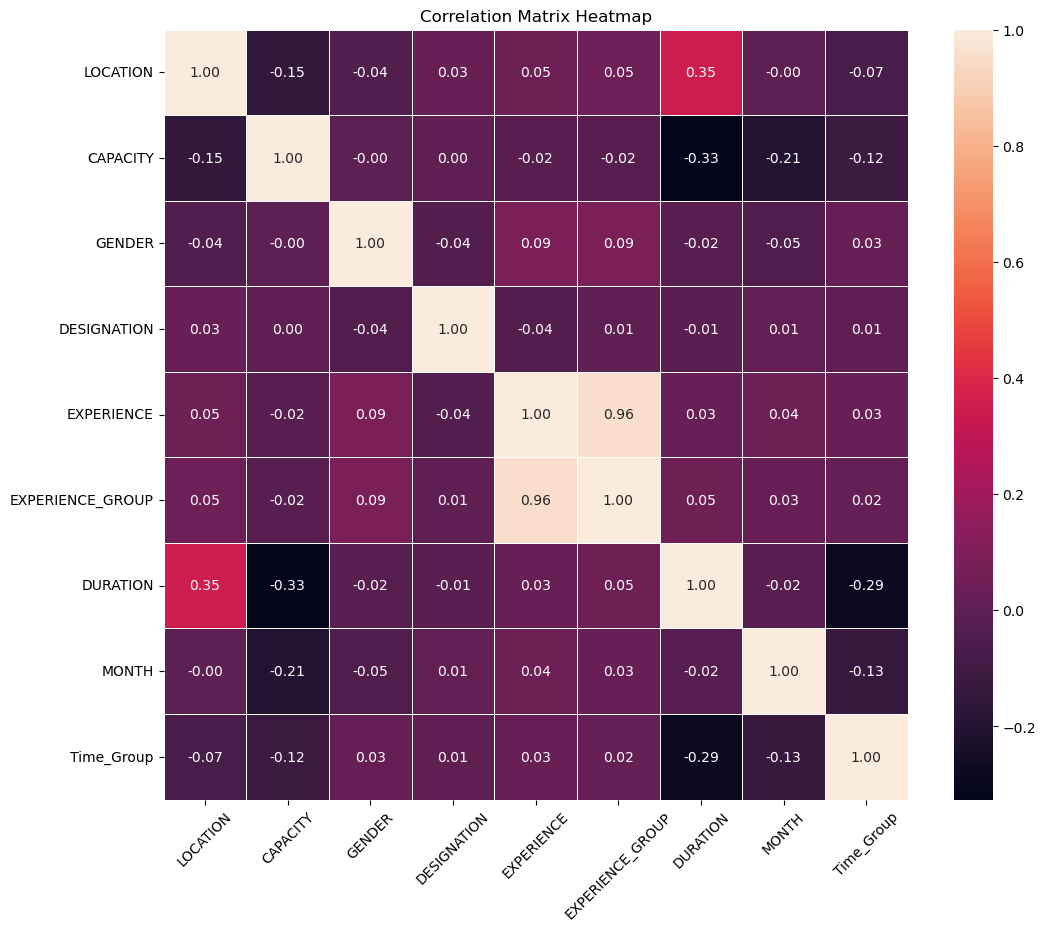

In [397]:
import seaborn as sns

# Drop non-numeric columns
numerics_df1 = df1.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = numerics_df1.corr()
print(correlation_matrix)

plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(correlation_matrix,annot=True, color=custom_palette, fmt=".2f", linewidths=0.5)

# Add a title
plt.title('Correlation Matrix Heatmap')

# Rotate the tick labels for better readability
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.show()


Chi-square and anova relation matrix

In [402]:
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# Assuming df is your DataFrame

# Function to calculate Chi-square statistic for boolean columns
def chi_square_for_bool(df):
    chi2_dict = {}
    for col in df.columns:
        if df[col].dtype == bool:
            observed = pd.crosstab(df[col], df['DOMAIN'])  # Assuming 'target_column' is your target variable
            chi2, p, dof, expected = chi2_contingency(observed)
            chi2_dict[col] = (chi2, p)
    return chi2_dict

# Function to calculate ANOVA relation matrix for numerical columns
def anova_relation_matrix(df):
    anova_dict = {}
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            groups = [df[df['DOMAIN'] == val][col].dropna() for val in df['DOMAIN'].unique()]
            anova_result = f_oneway(*groups)
            anova_dict[col] = anova_result
    return anova_dict

In [403]:
chi2_results = chi_square_for_bool(df1)
chi2_results


{'React': (5.443924918964798, 0.2447026724092209),
 'Javascript': (5.958439656078313, 0.20227359828454666),
 'Node': (2.3787651911948577, 0.6664680940950113),
 'Python': (5.193182475831867, 0.26804384278142884),
 'Machine_Learning': (0.5730181896713615, 0.9660142699438387),
 'NoSQL': (7.821449808161739, 0.0983420732387265),
 'ETL': (4.995004153648548, 0.2878104844757107),
 'Data_Warehouse': (5.223800921243742, 0.26509517052454495),
 'Big_Data': (3.905425628896971, 0.41895638039436545),
 'HTML': (9.682672146276998, 0.04612609104461374),
 'SQL': (8.47781729609256, 0.07556247777921009)}

In [404]:
anova_results = anova_relation_matrix(df1)
anova_results

{'LOCATION': F_onewayResult(statistic=13.389758631448913, pvalue=1.2411298523322214e-10),
 'CAPACITY': F_onewayResult(statistic=12.212634658947369, pvalue=1.0707960954283056e-09),
 'GENDER': F_onewayResult(statistic=0.5131861140624984, pvalue=0.7260683073755259),
 'DESIGNATION': F_onewayResult(statistic=1.2958115543434734, pvalue=0.2698096954433064),
 'EXPERIENCE': F_onewayResult(statistic=1.6688807740226292, pvalue=0.15498956447362008),
 'EXPERIENCE_GROUP': F_onewayResult(statistic=1.1848102864666485, pvalue=0.3158353706218111),
 'DURATION': F_onewayResult(statistic=11.683666597944041, pvalue=2.82180773522523e-09),
 'MONTH': F_onewayResult(statistic=108.00002629510439, pvalue=1.869679208908053e-76),
 'Time_Group': F_onewayResult(statistic=35.77121440011953, pvalue=5.9319484390708535e-28)}

Chi-square and Anova plots

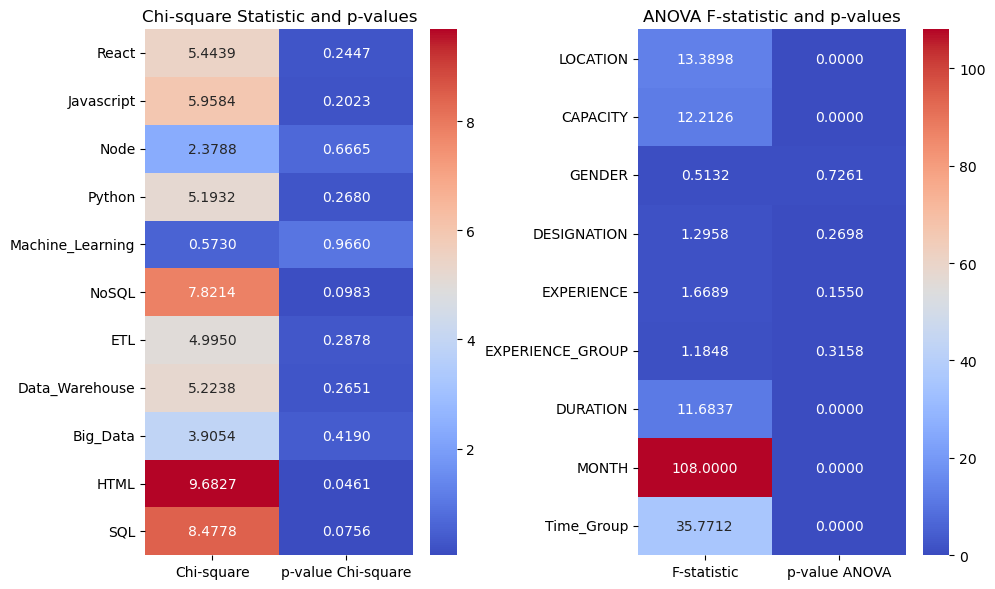

In [405]:
chi2_df = pd.DataFrame(chi2_results).T.rename(columns={0: 'Chi-square', 1: 'p-value Chi-square'})
anova_df = pd.DataFrame(anova_results).T.rename(columns={0: 'F-statistic', 1: 'p-value ANOVA'})

# Create heatmaps
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.heatmap(chi2_df, annot=True, cmap='coolwarm', fmt='.4f')
plt.title('Chi-square Statistic and p-values')

plt.subplot(1, 2, 2)
sns.heatmap(anova_df, annot=True, cmap='coolwarm', fmt='.4f')
plt.title('ANOVA F-statistic and p-values')

plt.tight_layout()
plt.show()


Checking all the columns

In [406]:
df1.columns

Index(['NAME', 'DOMAIN', 'LOCATION', 'CAPACITY', 'GENDER', 'DESIGNATION',
       'EXPERIENCE', 'React', 'Javascript', 'Node', 'Python',
       'Machine_Learning', 'NoSQL', 'ETL', 'Data_Warehouse', 'Big_Data',
       'HTML', 'SQL', 'EXPERIENCE_GROUP', 'DURATION', 'MONTH', 'Time_Group'],
      dtype='object')

In [411]:

df1 = df1.drop(columns=['GENDER','DESIGNATION','LOCATION','CAPACITY','EXPERIENCE'])

# MODEL GENERATION

In [412]:
df_model = df1.copy()
X = df_model.drop(columns=['DOMAIN','NAME'])
y = df_model['DOMAIN']

In [413]:
X

React  Javascript   Node  Python  Machine_Learning  NoSQL    ETL  \
0     True        True   True   False             False   True   True   
1     True        True  False   False             False   True  False   
2    False       False  False   False             False   True   True   
3    False       False  False   False             False   True   True   
4    False        True   True    True             False  False   True   
..     ...         ...    ...     ...               ...    ...    ...   
995  False       False   True    True              True  False  False   
996   True       False   True    True             False  False   True   
997  False        True   True    True              True  False  False   
998   True       False   True   False             False   True  False   
999   True        True   True    True              True  False  False   

     Data_Warehouse  Big_Data   HTML    SQL  EXPERIENCE_GROUP  DURATION  \
0             False      True   True   True                 2      10.0   
1              True      True   True  False                 3      16.0   
2              True      True  False  False                 0      19.0   
3              True      True  False  False                 0      13.0   
4              True      True   True   True                 0      16.0   
..              ...       ...    ...    ...               ...       ...   
995           False      True  False  False                 2      15.0   
996           False      True   True  False                 3      14.0   
997           False     False   True   True                 1       7.0   
998            True      True   True   True                 3      15.0   
999           False      True   True   True                 1      11.0   

     MONTH  Time_Group  
0       10           0  
1        7           1  
2        9           1  
3        5           0  
4        7           1  
..     ...         ...  
995      4           0  
996      4           0  
997     12           0  
998      4           0  
999     12           1  

[1000 rows x 15 columns]

In [414]:
X.columns

Index(['React', 'Javascript', 'Node', 'Python', 'Machine_Learning', 'NoSQL',
       'ETL', 'Data_Warehouse', 'Big_Data', 'HTML', 'SQL', 'EXPERIENCE_GROUP',
       'DURATION', 'MONTH', 'Time_Group'],
      dtype='object')

In [416]:
y

0      data-engineering
1            full-stack
2          data-science
3        data-analytics
4            full-stack
             ...       
995          full-stack
996            database
997          full-stack
998          full-stack
999        data-science
Name: DOMAIN, Length: 1000, dtype: object

In [419]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [420]:
X_encoded = X.apply(label_encoder.fit_transform)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

In [422]:
# Define the logistic regression model
lr = LogisticRegression()

# Define the grid search parameters
param_grid_lr = {'C': [0.1, 1, 10]}

# Initialize GridSearchCV
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy')

# Fit the model
grid_search_lr.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search_lr.best_params_)

# Get the best model
best_lr = grid_search_lr.best_estimator_

# Evaluate the best model on the test set
y_pred = best_lr.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

c:\Users\Hp\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Hp\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Best parameters: {'C': 0.1}
Classification Report:
                  precision    recall  f1-score   support

  data-analytics       0.00      0.00      0.00        44
data-engineering       0.54      0.30      0.39        43
    data-science       0.17      0.07      0.10        45
        database       0.41      0.62      0.49        71
      full-stack       0.50      0.73      0.59        97

        accuracy                           0.44       300
       macro avg       0.32      0.34      0.31       300
    weighted avg       0.36      0.44      0.38       300



c:\Users\Hp\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Hp\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

In [423]:
best_lr = LogisticRegression(C=0.1)

# Train the model
best_lr.fit(X_train, y_train)

# Make predictions
y_pred = best_lr.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                  precision    recall  f1-score   support

  data-analytics       0.00      0.00      0.00        44
data-engineering       0.54      0.30      0.39        43
    data-science       0.17      0.07      0.10        45
        database       0.41      0.62      0.49        71
      full-stack       0.50      0.73      0.59        97

        accuracy                           0.44       300
       macro avg       0.32      0.34      0.31       300
    weighted avg       0.36      0.44      0.38       300



c:\Users\Hp\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [424]:
from sklearn.tree import DecisionTreeClassifier

# Initialize decision tree model
model = DecisionTreeClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 1.0
Classification Report:
                  precision    recall  f1-score   support

  data-analytics       1.00      1.00      1.00        44
data-engineering       1.00      1.00      1.00        43
    data-science       1.00      1.00      1.00        45
        database       1.00      1.00      1.00        71
      full-stack       1.00      1.00      1.00        97

        accuracy                           1.00       300
       macro avg       1.00      1.00      1.00       300
    weighted avg       1.00      1.00      1.00       300



In [429]:
from sklearn.ensemble import RandomForestClassifier

# Initialize random forest model
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.81
Classification Report:
                  precision    recall  f1-score   support

  data-analytics       0.79      0.84      0.81        44
data-engineering       0.75      0.49      0.59        43
    data-science       0.74      0.82      0.78        45
        database       0.78      0.80      0.79        71
      full-stack       0.89      0.94      0.91        97

        accuracy                           0.81       300
       macro avg       0.79      0.78      0.78       300
    weighted avg       0.81      0.81      0.80       300



In [426]:
from sklearn.svm import SVC

# Initialize SVM model
model = SVC()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6233333333333333
Classification Report:
                  precision    recall  f1-score   support

  data-analytics       0.80      0.27      0.41        44
data-engineering       0.55      0.60      0.58        43
    data-science       1.00      0.16      0.27        45
        database       0.50      0.76      0.60        71
      full-stack       0.72      0.91      0.80        97

        accuracy                           0.62       300
       macro avg       0.71      0.54      0.53       300
    weighted avg       0.70      0.62      0.58       300



In [427]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize gradient boosting model
model = GradientBoostingClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 1.0
Classification Report:
                  precision    recall  f1-score   support

  data-analytics       1.00      1.00      1.00        44
data-engineering       1.00      1.00      1.00        43
    data-science       1.00      1.00      1.00        45
        database       1.00      1.00      1.00        71
      full-stack       1.00      1.00      1.00        97

        accuracy                           1.00       300
       macro avg       1.00      1.00      1.00       300
    weighted avg       1.00      1.00      1.00       300



Hyperparameter Tuning to get the best ml model

In [428]:



# Define hyperparameter grids for each model
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10]}
param_grid_dt = {'max_depth': [3, 5, 7, 9, 11]}
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7 ]}
param_grid_gb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2,0.5]}
param_grid_xgb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2, 0.5]}

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier()
}

# Define hyperparameter grids for each model
param_grids = {
    "Logistic Regression": param_grid_lr,
    "Decision Tree": param_grid_dt,
    "Random Forest": param_grid_rf,
    "Gradient Boosting": param_grid_gb,
    "XGBoost": param_grid_xgb
}

# Perform hyperparameter tuning for each model
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best parameters for {name}: {best_params}")
    print(f"Best score for {name}: {best_score}")

    # Evaluate the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy}")
    print(classification_report(y_test, y_pred))
    print("--------------------------------------------")



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Logistic Regression: {'C': 0.1}
Best score for Logistic Regression: 0.4685714285714285
Accuracy for Logistic Regression: 0.4533333333333333
                  precision    recall  f1-score   support

  data-analytics       0.30      0.07      0.11        44
data-engineering       0.58      0.33      0.42        43
    data-science       0.20      0.07      0.10        45
        database       0.42      0.62      0.50        71
      full-stack       0.49      0.74      0.59        97

        accuracy                           0.45       300
       macro avg       0.40      0.36      0.34       300
    weighted avg       0.42      0.45      0.40       300

--------------------------------------------
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Decision Tree: {'max_depth': 11}
Best score for Decision Tree: 1.0
Accuracy for Decision Tree: 1.0
                  precision    

ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hp\anaconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Hp\anaconda3\envs\mlenv\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\Hp\anaconda3\envs\mlenv\lib\site-packages\xgboost\sklearn.py", line 1471, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got ['data-analytics' 'data-engineering' 'data-science' 'database'
 'full-stack']


# Checking the Prediction

In [456]:

import numpy as np

#  the three test arrays
X_test1 = np.array([True, False, False, True, False, True, True, False, True, True, True, 3, 5, 7, 1])
X_test2 = np.array([False, False, False, False, False, False, False, False, False, False, False, 3, 5, 7, 1])
X_test3 = np.array([True, False, False, True, False, True, True, False, True, True, True, 3, 5, 0, 5])

# Reshaping test arrays to 2D arrays with a single row
X_test1_reshaped = X_test1.reshape(1, -1)
X_test2_reshaped = X_test2.reshape(1, -1)
X_test3_reshaped = X_test3.reshape(1, -1)

# Predict using the model
y_pred1 = model.predict(X_test1_reshaped)
y_pred2 = model.predict(X_test2_reshaped)
y_pred3 = model.predict(X_test3_reshaped)

# Print the predictions
print("Predictions for X_test1:", y_pred1)
print("Predictions for X_test2:", y_pred2)
print("Predictions for X_test3:", y_pred3)


Predictions for X_test1: ['database']
Predictions for X_test2: ['full-stack']
Predictions for X_test3: ['data-analytics']


c:\Users\Hp\anaconda3\envs\mlenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Hp\anaconda3\envs\mlenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Hp\anaconda3\envs\mlenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
predicted_domain='database'